## Predict Stock Market Closing Day Prices

### Import Libraries

In [44]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import livelossplot
from ta import *
from numpy import newaxis
from sklearn.preprocessing import MinMaxScaler
from mlpy import wavelet
from keras import regularizers
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
from keras.optimizers import Adam
from models import sparse_autoencoder
import warnings
warnings.filterwarnings("ignore")

### Add Technical Indicators

In [45]:
def moving_average(data, n):
    MA = pd.Series(data.rolling(n, min_periods=n).mean())
    return MA

In [46]:
def mtm(data, n):
    M = pd.Series(data.diff(n))
    return M

In [47]:
def rate_of_change(data, n):
    M = data.diff(n - 1)
    N = data.shift(n - 1)
    ROC = pd.Series(M / N)
    return ROC

In [48]:
# Load datas
df = pd.read_csv('article_data.csv', sep=',')

# Clean nan values
df = utils.dropna(df)

df['MACD'] = trend.macd(df['Close'])
df['CCI'] = trend.cci(df['High'], df['Low'], df['Close'])
df['ATR'] = volatility.average_true_range(df['High'], df['Low'], df['Close'])
df['BOLL'] = volatility.bollinger_mavg(df['Close'])
df['EMA20'] = trend.ema_fast(df['Close'], n_fast=20)
df['MA5'] = moving_average(df['Close'], 5)
df['MA10'] = moving_average(df['Close'], 10)
df['MTM6'] = mtm(df['Close'], 6*5*4.5)
df['MTM12'] = mtm(df['Close'], 12*5*4.5)
df['ROC'] = rate_of_change(df['Close'], 10)
df['SMI'] = momentum.stoch(df['High'], df['Low'], df['Close'])
df['WVAD'] = momentum.wr(df['High'], df['Low'], df['Close'])

print(df)
df.to_csv('article.csv')

            Date        Open        High         Low       Close    Volume  \
0     2004-08-19   50.050049   52.082081   48.028027   50.220219  44659000   
1     2004-08-20   50.555557   54.594593   50.300301   54.209209  22834300   
2     2004-08-23   55.430431   56.796795   54.579578   54.754753  18256100   
3     2004-08-24   55.675674   55.855854   51.836838   52.487488  15247300   
4     2004-08-25   52.532532   54.054054   51.991993   53.053055   9188600   
5     2004-08-26   52.527527   54.029030   52.382381   54.009010   7094800   
6     2004-08-27   54.104103   54.364365   52.897900   53.128128   6211700   
7     2004-08-30   52.692692   52.797798   51.056057   51.056057   5196700   
8     2004-08-31   51.201202   51.906906   51.131130   51.236237   4917800   
9     2004-09-01   51.401402   51.536537   49.884884   50.175175   9138200   
10    2004-09-02   49.644646   51.236237   49.519520   50.805805  15118600   
11    2004-09-03   50.525524   50.920921   49.709709   50.055054

In [49]:
for index, row in df.iterrows():
    if not row.isnull().values.any():
        firstIndex = index
        break
        
while not ((len(df)-firstIndex & (len(df)-firstIndex - 1)) == 0):
    firstIndex += 1

print(firstIndex)

604


## Normalize Data
- Using Min Max Scaler from Scikit Learn
- Scale data to range from 0 to 1

In [50]:
df_array = np.array(df.copy())
df_array = df_array[firstIndex:,1:]
close = np.array(df['Close'][firstIndex:].copy())
x_scale = MinMaxScaler()
df_array = x_scale.fit_transform(df_array)
y_scale = MinMaxScaler()
close = y_scale.fit_transform(close.reshape(-1, 1))
print(df_array)
print(close)

[[0.50035518 0.49308387 0.52899309 ... 0.63880594 1.         1.        ]
 [0.51197188 0.5098248  0.53590121 ... 0.64535462 0.85531815 0.85531815]
 [0.50328025 0.49888048 0.51722841 ... 0.58386634 0.73086819 0.73086819]
 ...
 [0.05398857 0.07142108 0.08593261 ... 0.34609257 0.35021561 0.35021561]
 [0.07423429 0.08366292 0.10016745 ... 0.34864542 0.40912995 0.40912995]
 [0.09769758 0.13097704 0.11915431 ... 0.5198331  0.72265289 0.72265289]]
[[0.51111798]
 [0.50963148]
 [0.4951791 ]
 [0.47566845]
 [0.47963249]
 [0.46123671]
 [0.45754107]
 [0.49887481]
 [0.47620524]
 [0.49220605]
 [0.48524825]
 [0.48906784]
 [0.50389184]
 [0.46311553]
 [0.46259939]
 [0.43299267]
 [0.44191188]
 [0.43887683]
 [0.44098276]
 [0.42211212]
 [0.41467947]
 [0.41635184]
 [0.43045318]
 [0.421245  ]
 [0.43873231]
 [0.44319191]
 [0.45095489]
 [0.45093424]
 [0.44013628]
 [0.42838855]
 [0.39502424]
 [0.39642821]
 [0.39390937]
 [0.37419221]
 [0.37887891]
 [0.41315163]
 [0.40920823]
 [0.40730876]
 [0.40367505]
 [0.407370

### Denoise Data with Wavelet Transform

In [51]:
for i in range(df_array.shape[1]):
    df_array[:,i] = wavelet.dwt(df_array[:,i], wf='h'.encode('utf-8'), k=2)
    df_array[:,i] = wavelet.dwt(df_array[:,i], wf='h'.encode('utf-8'), k=2)
print(df_array)

[[ 0.67144428  0.67898449  0.69105466 ...  0.5635001   0.50891312
   0.50891312]
 [ 0.63519552  0.66439374  0.68599918 ...  0.54100784  0.59747053
   0.59747053]
 [ 0.906087    0.88688478  0.94218501 ...  0.62672972  0.58945457
   0.58945457]
 ...
 [-0.00120137 -0.00296105 -0.00184218 ...  0.00919107 -0.05541147
  -0.05541147]
 [ 0.00963188  0.0120012   0.02255602 ...  0.04052211  0.14191091
   0.14191091]
 [ 0.02300365  0.01947183  0.00363199 ... -0.00658151 -0.01834633
  -0.01834633]]


### Load Data
- Split data into training and test sets as sequences
- Training set: 90%
- Test set: 10%

In [52]:
data = np.array(df_array[:,1:])

row = round(0.9 * data.shape[0])
x_train = data[:int(row), :]
y_train = close[:int(row)]
x_test = data[int(row):, :]
y_test = close[int(row):]

### Encode Features using Stacked Autoencoders

In [53]:
def encoder(inputs):
    input_data = Input(shape=(inputs.shape[1],))
    
    encoded = Dense(10, activation='sigmoid',
                activity_regularizer=regularizers.l1(10e-5))(input_data)
    
    decoded = Dense(inputs.shape[1], activation='sigmoid')(encoded)

    autoencoder = Model(input_data, decoded)

    encoder = Model(input_data, encoded)
    
    # Can test this learning rate
    opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    autoencoder.compile(loss='mse', optimizer=opt)
    
    plot_losses = livelossplot.PlotLossesKeras()
    
    # Can test these hyperparameters
    autoencoder.fit(inputs, inputs,
                epochs=3000,
                batch_size=60,
                shuffle=True,
                validation_split=0.1, 
                callbacks=[plot_losses])
    
    return encoder

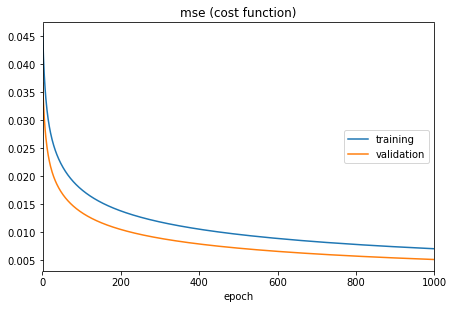

In [54]:
auto1 = encoder(x_train)
auto1_out = auto1.predict(x_train)

auto2 = encoder(auto1_out)
auto2_out = auto2.predict(auto1_out)

auto3 = encoder(auto2_out)
auto3_out = auto3.predict(auto2_out)

auto4 = encoder(auto3_out)

x_train = auto4.predict(auto3_out)
x_test = auto4.predict(auto3.predict(auto2.predict(auto1.predict(x_test))))

### Prepare Time-Series Data
- Set Sequence Length to be 4

In [55]:
def x_shift(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    
    result = result[:, :-1]
    
    result = np.reshape(result, (1, result.shape[0], result.shape[1]))
    
    return result

def y_shift(data, seq_len):
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)
    
    result = result[:, -1]
    
    result = np.reshape(result, (result.shape[0]))
    
    return result

In [56]:
seq_len = 4

x_train = np.array(x_train)
x_test = np.array(x_test)

for index, column in enumerate(x_train.T):
    x_temp = x_shift(column, seq_len)
    if index == 0:
        x_placeholder = np.empty((x_train.shape[1],x_temp.shape[1],x_temp.shape[2]))
    x_placeholder[index] = x_temp
    
x_train = x_placeholder

for index, column in enumerate(x_test.T):
    x_temp = x_shift(column, seq_len)
    if index == 0:
        x_placeholder = np.empty((x_test.shape[1],x_temp.shape[1],x_temp.shape[2]))
    x_placeholder[index] = x_temp
    
x_test = x_placeholder

y_train = y_shift(y_train, seq_len)
y_test = y_shift(y_test,seq_len)

print(x_train.shape)

(10, 456, 4)


### Build Model

- Build a model with five hidden layers of LSTM
- Learning Rate = 0.05
- Uses Adam optimizer and Mean Squared Error for loss function

In [57]:
def build_model(layers):
    model = Sequential()

    model.add(LSTM(return_sequences=True, input_shape=(None, layers[0]), units=layers[1]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[2]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[3]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=True, units=layers[4]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(LSTM(return_sequences=False, units=layers[5]))
    # Can test dropout rate
    model.add(Dropout(0.5))
    
    model.add(Dense(units=layers[6]))
    model.add(Activation("linear"))

    start = time.time()
    
    opt = Adam(lr=0.05, beta_1=0.9, beta_2=0.999, decay=0.01)
    
    model.compile(loss="mse", optimizer=opt, metrics=["accuracy"])
    
    print("> Compilation Time : ", time.time() - start)
    
    return model

### Test Model

- Batch Size = 60
- Number of Epochs = 5000

In [58]:
global_start_time = time.time()
epochs  = 5000
batch_size = 60

x_train = np.array(x_train).reshape(x_train.shape[1], seq_len, x_train.shape[0])
x_test = np.array(x_test).reshape(x_test.shape[1], seq_len, x_test.shape[0])

# Can test the hidden layer sizes
model = build_model([x_train.shape[2], 100, 100, 100, 100, 100, 1])

model.summary()

> Compilation Time :  0.022358179092407227
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_6 (LSTM)                (None, None, 100)         44400     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_7 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_8 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 100)         0         
_________________________________________________________________
lstm_9 (LSTM)                (Non

In [ ]:
plot_losses = livelossplot.PlotLossesKeras()

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[plot_losses])

model.save('article_model.h5')

model.save_weights('article_model_weights.h5')

print('Training duration (s) : ', time.time() - global_start_time)

Epoch 612/5000
410/410 [==============================] - 0s 399us/step - loss: 0.0238 - acc: 0.0024 - val_loss: 0.0985 - val_acc: 0.0000e+00


### Plot

In [ ]:
def plot_results(predicted_data, true_data):
    fig = plt.figure(facecolor='white')
    ax = fig.add_subplot(111)
    ax.plot(true_data, label='True Data')
    plt.plot(predicted_data, label='Prediction')
    plt.legend()
    plt.show()

### Predictions

In [ ]:
predicted = model.predict(x_test)

# scale back 
predicted = y_scale.inverse_transform(predicted)
y_test = y_scale.inverse_transform(y_test.reshape(-1, 1))
predicted = np.reshape(predicted, (predicted.size,))

plot_results(predicted, y_test)